In [1]:
import torch
from model import LUNet
from matplotlib import pyplot as plt
import numpy as np

from torch.optim.lr_scheduler import StepLR
from train import training_routine_gaussian, training_routine_uniform, training_routine_uniform_method2
from test import testing_routine_uniform_method2
from functions import uniform_circle_log_likelihood, uniform_circle_log_likelihood_method2

from pathlib import Path

from visuals import plot_transformed_grid_and_density, compute_uniform_circle_density

In [2]:
torch.set_default_dtype(torch.float64)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

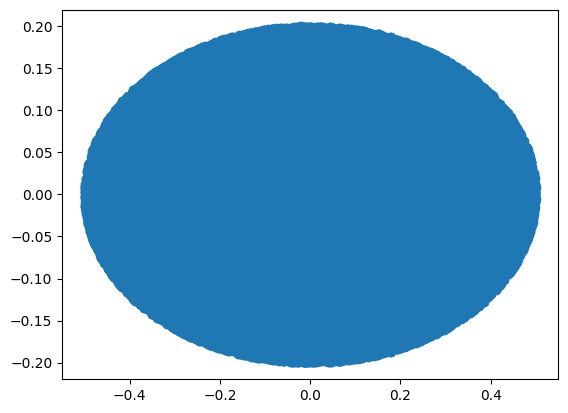

In [3]:
def generate_ellipse(max_num = 10000, scale=(0.5,0.2)):
    data = (torch.rand((max_num,2))-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale)
    return data

train_loader = generate_ellipse(100000)
test_loader = generate_ellipse(10000)
plt.scatter(np.array(train_loader)[:,0], np.array(train_loader)[:,1])

In [4]:
model = LUNet(num_lu_blocks=2, layer_size = 2).to(device)


In [93]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [94]:
%%time
batch_size = 1024
#density_param=(5,0.2)

# grid points for grid distortion
grid_range = 3
x_range=(-grid_range, grid_range)
y_range=(-grid_range, grid_range)
grid_width = 30

x = np.linspace(*x_range, grid_width)
y = np.linspace(*y_range, grid_width)

xv, yv = np.meshgrid(x, y, indexing='xy')
horizontal_lines = np.stack((xv, yv), axis=2)
all_grid_points = np.concatenate(horizontal_lines, axis=0)
grid_input = torch.tensor(all_grid_points).to(device)

def check_not_nan_transform(all_grid_points: torch.Tensor, grid_input: torch.Tensor):
    with torch.no_grad():
        t = model(grid_input, reverse=True)
        return torch.sum(torch.isnan(t)) == 0

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    #density_param = (1+epoch/4, 0.2)
    #print("\nEpoch {}:".format(epoch))
    # if epoch % 100 == 1:
    #     train_with_grid_penalty = check_not_nan_transform(all_grid_points, grid_input)
    #     print(train_with_grid_penalty)

    if epoch % 2 == 3:
        train_with_grid_penalty=True
    else:
        train_with_grid_penalty=False
    
    if train_with_grid_penalty:
        training_routine_uniform_method2(model, device, train_loader, optimizer, epoch, batch_size, loss_function=uniform_circle_log_likelihood_method2,
                                        grid_penalty=True, grid_input=grid_input, penalty_weight=1)
    else:
        training_routine_uniform_method2(model, device, train_loader, optimizer, epoch, batch_size, loss_function=uniform_circle_log_likelihood_method2)
    
    testing_routine_uniform_method2(model, device, test_loader, batch_size,loss_function=uniform_circle_log_likelihood_method2)
    #save_model_for_animation(model=model, epoch=epoch)
    scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 84.72it/s]


Test set: Average loss: -1.7860


100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 111.71it/s]


Test set: Average loss: -2.0444


100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 108.18it/s]


Test set: Average loss: -1.9233


100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 100.92it/s]


Test set: Average loss: -2.0589


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 96.89it/s]


Test set: Average loss: -1.9984


 87%|███████████████████████████████████████████████████████████████████████▏          | 66/76 [00:00<00:00, 93.89it/s]


KeyboardInterrupt: 

In [95]:
save_model = True
checkpoints_dir= './checkpoints/'
data = 'Ellipse'
checkpoint_number =  31
num_lu_blocks = 2
layer_size = 2

if save_model:
    save_path = Path(checkpoints_dir) / Path("{}/experiment{}.pth".format(data, checkpoint_number))
    save_path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print("Saved checkpoint:", save_path)

Saved checkpoint: checkpoints\Ellipse\experiment31.pth


In [4]:
checkpoint_number =  31
num_lu_blocks = 2
layer_size = 2

In [5]:
# checkpoint_number =  4
# num_lu_blocks = 12
# layer_size = 2
# density_param = (1+30/4, 0.2)

def load_model(num_lu_blocks=12, layer_size = 2, path=f"./checkpoints/Ellipse/experiment{checkpoint_number}.pth"):
    model = LUNet(num_lu_blocks=num_lu_blocks, layer_size = layer_size).to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [6]:
model = load_model(num_lu_blocks, layer_size, f"./checkpoints/Ellipse/experiment{checkpoint_number}.pth")

In [7]:
sampling_data = generate_ellipse(1000, (1, 1))

C:\Users\Admin\AppData\Local\Temp\ipykernel_28120\3882102552.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model_inverted(torch.tensor(sampling_data, dtype=torch.float32).to(device))


0

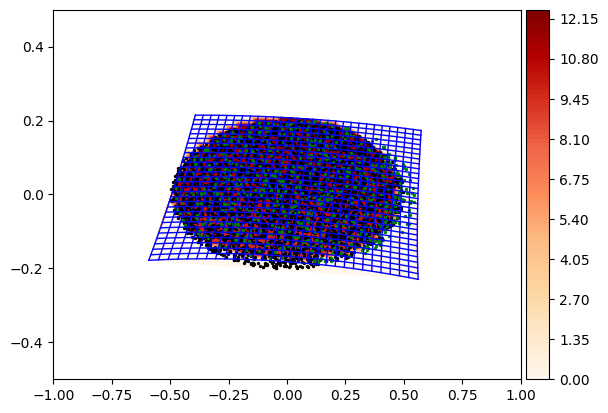

In [177]:
density_param = (1000,0.1)
scale=2
factor=1
plot_generating_uniform_density(model2, inverted_model, device, density_param, train_loader, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

0

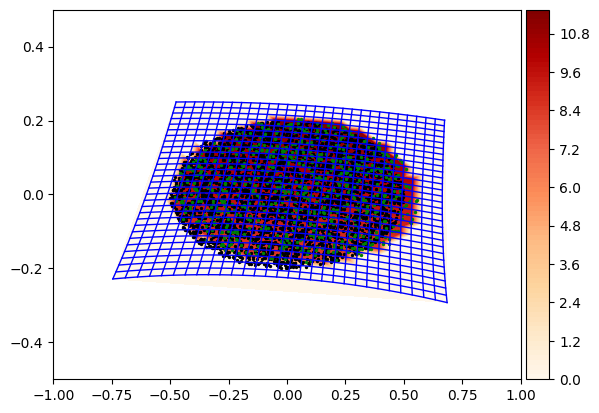

In [11]:
scale=2
factor=1.2

plot_transformed_grid_and_density(model, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

In [ ]:
# TODO: 
# - grid distortion (DONE)
# - plot with real density function  (DONE)
# - inside/outside decider 

# - more complicated shapes
# - 3D shapes 
# - Animation

In [ ]:
def generate_banana():
    train_loader = generate_ellipse(100000)
    train_loader[0, :] = train_loader[0, :] + 3*train_loader[0, :]**2
    return train_loader